In [1]:
# Packages related to NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Packages related to data
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Packages related to image transformations
import torchvision
from torchvision import transforms

# Package for visualization
import matplotlib.pyplot as plt

# Package for array data
import numpy as np

### Useful function

In [33]:
# Function to create confusion matrix
def create_confusion_matrix(y_value, y_pred, title = 'Confusion Matrix'):
    conf_matrix = metrics.confusion_matrix(y_value, y_pred)

    # Display the  confusion matrix
    display_conf = metrics.ConfusionMatrixDisplay(
        conf_matrix,
        display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
        # ["Cigar-shaped smooth", "In between smooth", "completely round smooth", "edge-on", "spiral"]
        )

    display_conf.plot(cmap='Blues', values_format='d')

    plt.title(title)
    plt.show()

Image preprocessing

In [3]:
image_preprocessing = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
        )
])

Load data

In [4]:
path = '/kaggle/input/galaxy-zoo-classification/Train_images/Train_images/'
data = datasets.ImageFolder(root=path, transform=image_preprocessing)

## Split data into train and test

In [5]:
# Define the size of the validation set
# Define the size of the validation and test sets
validation_split = 0.3
test_split = 0.2

# Calculate sizes of validation and test sets
val_size = int(validation_split * len(data))
test_size = int(test_split * len(data))
train_size = len(data) - val_size - test_size

# Split the dataset into training, validation, and test sets
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

### Visualize sample data

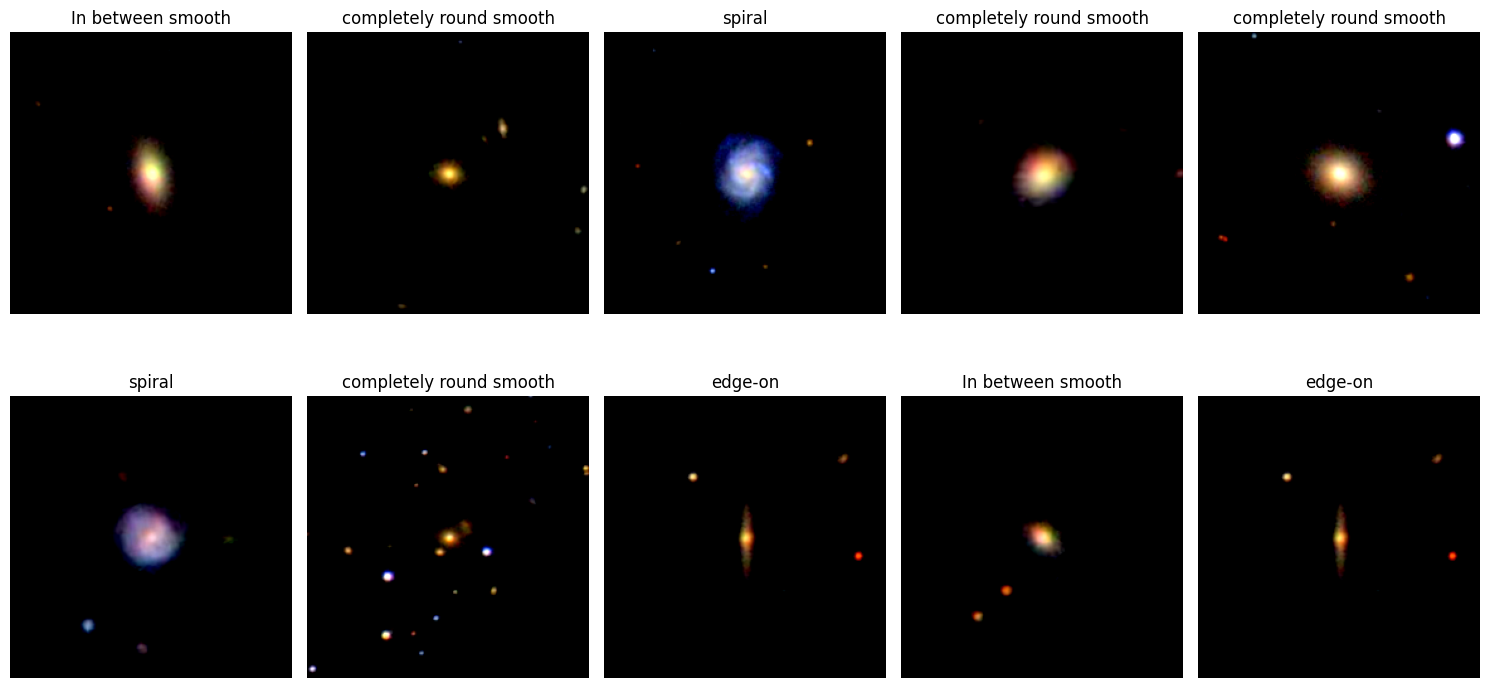

In [93]:
class_labels = ["Cigar-shaped smooth", "In between smooth", "completely round smooth", "edge-on", "spiral"]

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to show images with labels
def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{class_labels[label]}")
    plt.axis("off")

# Subplot to display 10 images
plt.figure(figsize=(15, 8))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = np.random.randint(0, len(images))
    imshow(torchvision.utils.make_grid(images[index]), labels[index].item())

plt.tight_layout()
plt.show()

## Load model

In [9]:
%%capture
base_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

## Free the model

In [10]:
for parameter in base_model.parameters():
    parameter.requires_grad = False

## Add new layers

In [11]:
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x

In [12]:
base_model.fc = CustomHead(in_features=2048, num_classes=5)

In [14]:
## Check how many learnable parameters do we have
print(sum(model_param.numel() for model_param in base_model.parameters() if model_param.requires_grad))

10245


## Function to train the model

In [15]:
def train(
        model,
        criterion,
        train_loader,
        validation_loader,
        optimizer,
        epochs,
        device
):

    model_metrics = {'training_loss': [], 'validation_accuracy': []}

    for epoch in range(epochs):
        running_loss = 0

        for inputs, targets  in train_loader:
            optimizer.zero_grad()
            
            # Use GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Make prediction
            output = model(inputs)

            # Calculate the loss
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.data.item()

        model_metrics['training_loss'].append(running_loss)

        model.eval()

        # track correct prediction
        correct = 0
        for inputs, targets in validation_loader:
            
            # Use GPU
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Make prediction
            output = model(inputs)

            # Get the class that has the maximum value
            _, label = torch.max(output, 1)

            # Check if the predicted value matches with the actuall class
            correct += (label == targets).sum().item()

        accuracy = 100 * (correct / len(validation_loader.dataset))

        model_metrics['validation_accuracy'].append(accuracy)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Accuracy: {:.4f}%'.format(
            epoch + 1,
            running_loss,
            accuracy
        ))

    return model_metrics

## Trainin setup

In [16]:
## Create the loss function criterion
criterion = nn.CrossEntropyLoss()

## Create the optimizer
optimizer = optim.Adam(base_model.parameters(), lr = 0.001)

## Define the number of epochs
epochs = 20

## Leverage GPU resources to expedite the training process.

In [17]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('GPU is available')
    device = torch.device("cuda:0")
else:
    print('Training on CPU')
    device = torch.device("cpu")

GPU is available


## Train the model

In [18]:
## Create the loss function criterion
criterion = nn.CrossEntropyLoss()

## Create the optimizer
optimizer = optim.Adam(base_model.parameters(), lr = 0.001)

## Define the number of epochs
epochs = 20

Epoch: 1, Training Loss: 213.7981, Validation Accuracy: 66.6319%
Epoch: 2, Training Loss: 169.0779, Validation Accuracy: 68.5539%
Epoch: 3, Training Loss: 156.8331, Validation Accuracy: 68.3455%
Epoch: 4, Training Loss: 149.3085, Validation Accuracy: 69.0749%
Epoch: 5, Training Loss: 142.7353, Validation Accuracy: 69.3412%
Epoch: 6, Training Loss: 137.6923, Validation Accuracy: 67.9981%
Epoch: 7, Training Loss: 134.4662, Validation Accuracy: 69.0633%
Epoch: 8, Training Loss: 130.3474, Validation Accuracy: 69.4917%
Epoch: 9, Training Loss: 128.3916, Validation Accuracy: 68.6581%
Epoch: 10, Training Loss: 125.5406, Validation Accuracy: 69.1096%
Epoch: 11, Training Loss: 122.9316, Validation Accuracy: 68.6697%
Epoch: 12, Training Loss: 120.9865, Validation Accuracy: 69.1096%
Epoch: 13, Training Loss: 118.6975, Validation Accuracy: 69.0865%
Epoch: 14, Training Loss: 117.0506, Validation Accuracy: 68.6465%
Epoch: 15, Training Loss: 115.3237, Validation Accuracy: 68.9128%
Epoch: 16, Training

## Test the model on our test data

In [20]:
def test(model, criterion, test_loader, device):
    model.eval()
    test_losses = []
    correct = 0
    
    test_metrics = {
        "predictions": [],
        "targets_list": []
    }
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)
            test_losses.append(loss.item())

            _, predicted = torch.max(output, 1)
            correct += (predicted == targets).sum().item()

            # Append predictions and targets to lists
            test_metrics["predictions"].extend(predicted.cpu().numpy())
            test_metrics["targets_list"].extend(targets.cpu().numpy())

    average_test_loss = sum(test_losses) / len(test_losses)
    accuracy = 100 * correct / len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}%'.format(average_test_loss, accuracy))

    return average_test_loss, accuracy, test_metrics, test_losses

In [21]:
# Test the model and get the results in lists
test_loss, test_accuracy, test_metrics, test_loss = test(base_model, 
                                                    criterion, 
                                                    test_loader,
                                                    device)

Test Loss: 0.7445, Test Accuracy: 69.2428%


# Fine tune the model

In [29]:
# Unfreeze some layers
for parameter in base_model.parameters():
    parameter.requires_grad = True

# New learning rate for fine-tuning
new_optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

new_epochs = 10

### Train the fine tuned model

In [30]:
fine_tune_model = train(base_model, 
                        criterion,
                        train_loader,  
                        val_loader, 
                        new_optimizer, 
                        new_epochs,
                        device)

Epoch: 1, Training Loss: 87.1104, Validation Accuracy: 92.5669%
Epoch: 2, Training Loss: 42.4588, Validation Accuracy: 92.2079%
Epoch: 3, Training Loss: 33.1019, Validation Accuracy: 92.3700%
Epoch: 4, Training Loss: 22.9839, Validation Accuracy: 93.4468%
Epoch: 5, Training Loss: 18.2516, Validation Accuracy: 93.0763%
Epoch: 6, Training Loss: 16.3069, Validation Accuracy: 94.1299%
Epoch: 7, Training Loss: 13.2092, Validation Accuracy: 94.4541%
Epoch: 8, Training Loss: 10.8710, Validation Accuracy: 91.7911%
Epoch: 9, Training Loss: 10.6471, Validation Accuracy: 94.1646%
Epoch: 10, Training Loss: 8.9436, Validation Accuracy: 91.9301%


### Test the fine tuned model on our test data

In [31]:
# Test the model and get the results in lists
test_loss, test_accuracy, test_metrics, test_loss = test(base_model, 
                                                    criterion, 
                                                    test_loader,
                                                    device)

Test Loss: 0.3048, Test Accuracy: 92.7579%


###  Print classification report

In [32]:
from sklearn import metrics

print(metrics.classification_report(
    test_metrics["targets_list"],
    test_metrics["predictions"]
))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.71      0.51      0.59       117
           1       0.95      0.85      0.90      1573
           2       0.92      0.95      0.94      1660
           3       0.93      0.97      0.95       793
           4       0.93      0.99      0.96      1615

    accuracy                           0.93      5758
   macro avg       0.89      0.85      0.87      5758
weighted avg       0.93      0.93      0.93      5758



### Plot the confusion matrix

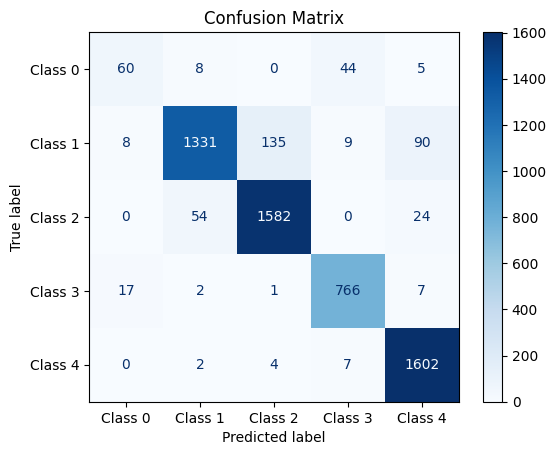

In [87]:
# Import the function we created above
conf_matrix = create_confusion_matrix(
    test_metrics["targets_list"],
    test_metrics["predictions"]
)


## Save the model

In [92]:
# Save the trained model
torch.save(base_model.state_dict(), 'galaxy_zoo_model.pth')


#### I'm still in the process of learning, so if you have any comments, suggestions, or questions about my code, please feel free to share your insights. I'm eager to improve and welcome any feedback you might have.